# Combination of housing and transportaion costs (block groups level)

### Preparation: import package

In [1]:
# a handy trick to get rid of deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from configparser import ConfigParser
import matplotlib.pyplot as plt
import pandas as pd
from census import Census
from us import states
import pyproj
import geopandas as gpd
import numpy as np
import math
import platform
import datetime
import sys
import os
import subprocess
#import seaborn as sb


from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.path import Path
import matplotlib.patheffects as PathEffects
from matplotlib import patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import palettable.matplotlib as mplpal
import palettable.colorbrewer.sequential as mplpals
from legendgram import legendgram
import mapclassify # used for reproducing the group of data in natural breaks
%matplotlib inline


### Preparation: updated stored files or links

In [3]:
# Read all environment variables
config = ConfigParser()
config.readfp(open(r'Config.py'))

tx_state = config.get('General',"tx_state") #tx_state shapefile
tx_county  = config.get('General',"tx_county") # tx_county shapefile
tx_bgs = config.get('General',"tx_bgs") # tx_bgs shapefile

housing = config.get('HTcosts',"housing") # import housing expense
transit = config.get('HTcosts',"transit") # import transit expense
auto = config.get('HTcosts',"auto") # import auto expense


In [4]:
#import each dataframe created by previous notebooks (housing, transit, auto-use)
housing =pd.read_csv (housing)
transit_cost =pd.read_csv (transit)
transit_cost = transit_cost [['geoid','transitcost_hh']]# only maintain necessary variables
autoexp =pd.read_csv (auto)


In [5]:
# Access shapefile of Texas state
tx_state = gpd.read_file(tx_state) 

# Access shapefile of Texas county
tx_county = gpd.read_file(tx_county)

# Access shapefile of Texas census block groups
tx_bgs = gpd.read_file(tx_bgs)

## A) Produce the final comprehensive dataframe for H+T costs

In [6]:
# Merge all data frames into one
H_Tcost = autoexp.merge(transit_cost, how='left', on='geoid').merge(housing, how='left', on='geoid')
H_Tcost.geoid = H_Tcost.geoid.astype(str)

H_Tcost = H_Tcost.rename(columns = {'housing_mortgage':'housing_mortgage_monthly',
                                   'rent_cost':'housing_rent_monthly'
                                   }) # specify columns to keep

calcualte some needed variables in the final comphrehensive dataframe

In [7]:
#produce detailed total expense combination
H_Tcost ['Transportation_Cost'] = H_Tcost ['driving_cost_year'] + H_Tcost ['transitcost_hh']+ H_Tcost ['carownership_expense_hh'] 
H_Tcost ['combined H+T'] = H_Tcost ['driving_cost_year'] + H_Tcost ['transitcost_hh']+ H_Tcost ['carownership_expense_hh'] + H_Tcost ['ave_housing_yearly'] 


#Transportation costs as a share of total household expenditures
H_Tcost ['transportation share'] = H_Tcost ['Transportation_Cost'] / H_Tcost ['annual_expense_individual'] *100

H_Tcost.loc[H_Tcost['transportation share'] >100, ['transportation share']] = 100


# H+T costs as a share of median household income
H_Tcost ['combined H+T share'] = (H_Tcost ['combined H+T'] / H_Tcost ['medincome']) *100


H_Tcost.replace([np.inf, -np.inf], 0, inplace=True)
H_Tcost = H_Tcost .fillna(0)

H_Tcost.loc[H_Tcost['combined H+T share'] >100, ['combined H+T share']] = 100


H_Tcost ['Affordability'] = "Unapplicable"
H_Tcost.loc[H_Tcost ['combined H+T share'] >=45, "Affordability"] = "Un-affordable" # place needs to have affordable housing support
H_Tcost.loc[H_Tcost ['combined H+T share'] < 45, "Affordability"] = "Affordable"


H_Tcost.to_csv('H_Tcost.csv',index=False)
H_Tcost = H_Tcost.fillna(0)

## B. Mapping for CoA report

Mapping Preparation (Merge H+T dataframe and TIGER/LINE file)

In [8]:
### State's Shapfile ###
# Access shapefile of Texas state, reproject shapefile to the EPSG identifier of WGS84
tx_state  = tx_state.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_state  = tx_state [['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_state.columns= tx_state.columns.str.lower()


# narrow down to TX state

state = ['48']
tx_state   = tx_state [tx_state ['geoid'].isin(state)] 

tx_state ['namelsad'] = tx_state ['name'] # in order to plotting the names


### County's Shapfile ###
# Access shapefile of Texas county, reproject shapefile to the EPSG identifier of WGS84
tx_county = tx_county.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_county = tx_county[['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_county.columns= tx_county.columns.str.lower()


# narrow down to CAMPO county

county = ['48021', '48053', '48055','48209','48453','48491']
campo_county = tx_county[tx_county['geoid'].isin(county)]
campo_county.reset_index(drop=True, inplace=True)

campo_county ['namelsad'] = campo_county ['name'] # in order to plotting the names


### Block groups' Shapfile ###
# Access shapefile of Texas census block groups, reproject shapefile to the EPSG identifier of WGS84
tx_bgs = tx_bgs.to_crs(epsg = 4269)

#clean data through keeping only necessary variables

tx_bgs = tx_bgs[['GEOID', 'ALAND','geometry']]

# rename  columns to lower case
tx_bgs.columns= tx_bgs.columns.str.lower()

# merge shapefile and H+T cost dataframe
tx_bgs.geoid = tx_bgs.geoid.astype(str)
H_Tcost.geoid = H_Tcost.geoid.astype(str)


H_Tcost = tx_bgs.merge(H_Tcost, on = "geoid")
H_Tcost = H_Tcost.drop(columns = {'aland'})


#### Transportation costs as a share of total annual household expenditures

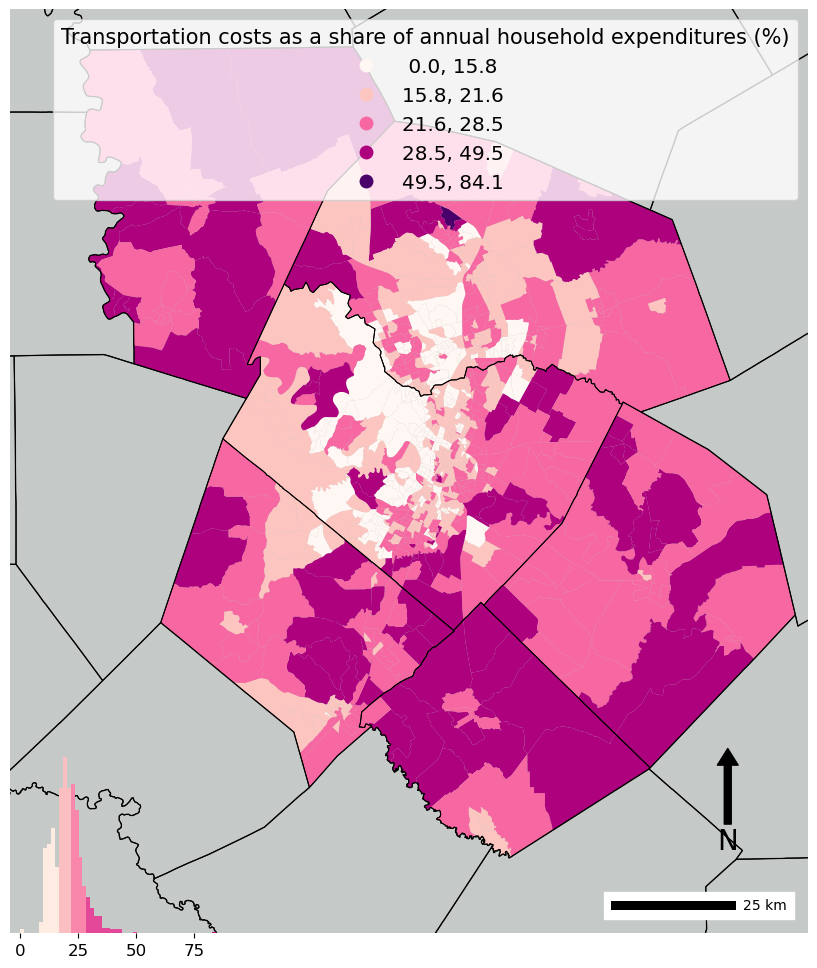

In [9]:
# Create single comprehensive subplots 


variable = H_Tcost['transportation share'] # define target variable


fig, ax = plt.subplots(1, 1, figsize = (20, 12))# set plot size
ax.axis([-98.6,-97,29.5,31.1])# set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)


ax.axis('off') #Get rid of grids, and x/y axis

# add legend title

ax.get_legend().set_title("Transportation costs as a share of annual household expenditures (%)",prop={'size':15}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/t_costs_share.png')

#### Combined H+T costs

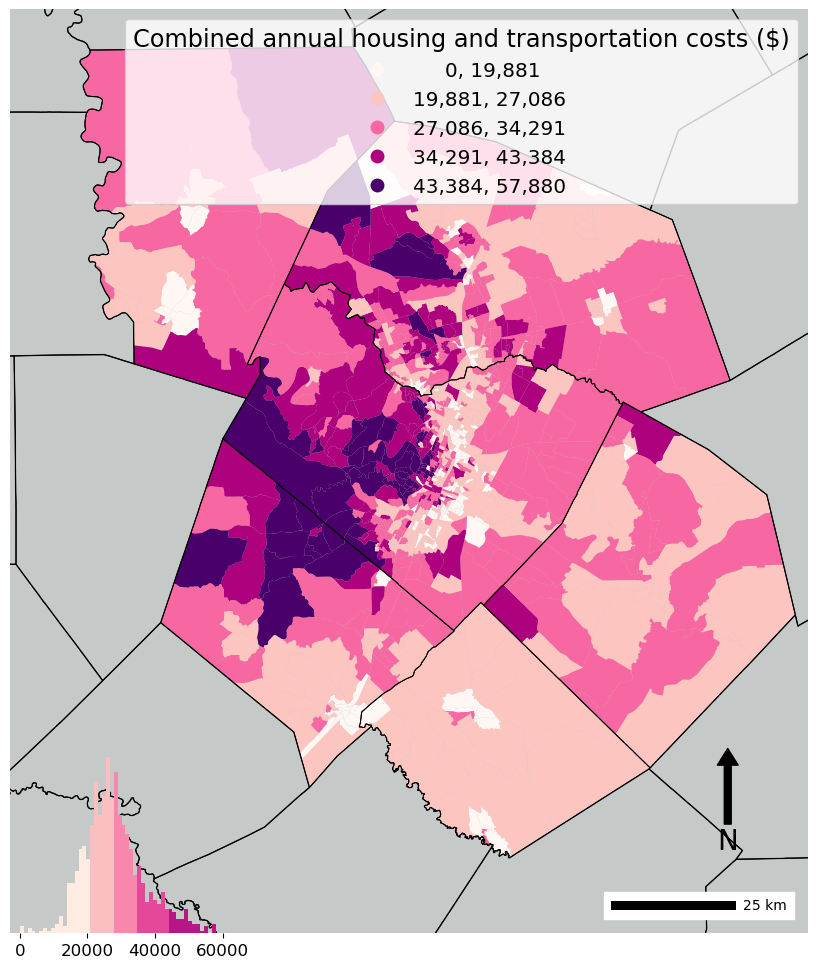

In [10]:
# Create single comprehensive subplots 


variable = H_Tcost['combined H+T'] # define target variable

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1]) # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.0f}")),
            zorder = 1)

 

ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Combined annual housing and transportation costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )


fig.savefig('images/H_T_costs.png')

#### Combined H+T costs as a share of the median household income

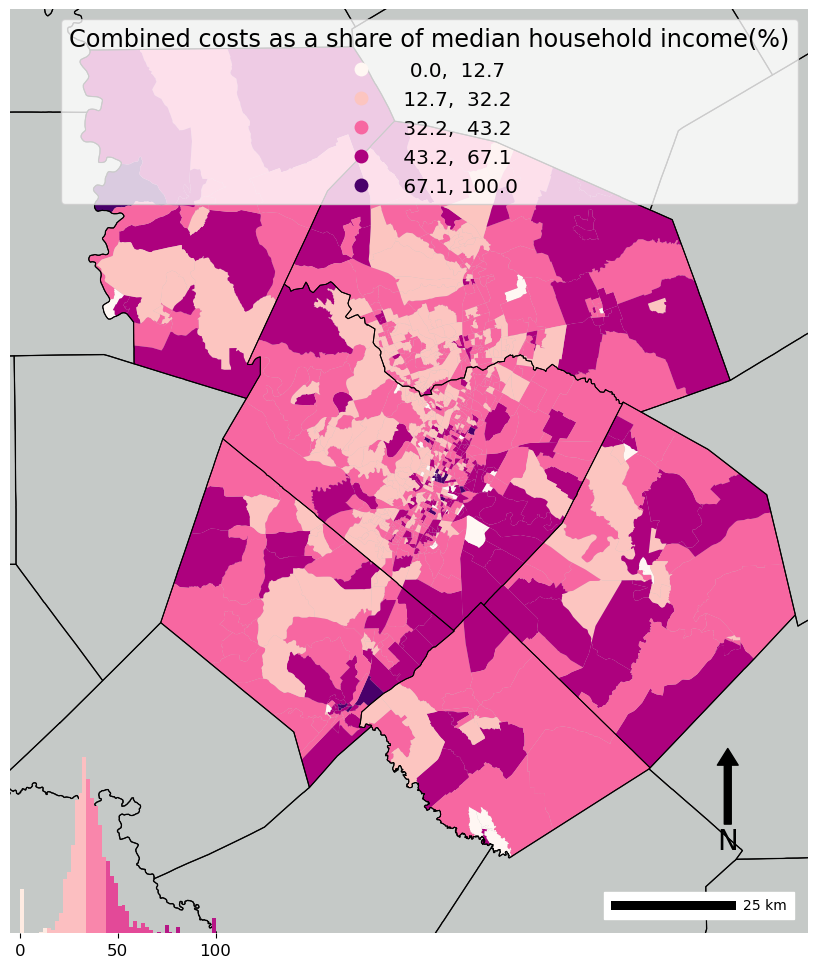

In [11]:
# Create single comprehensive subplots 


variable = H_Tcost['combined H+T share'] # define target variable


fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1]) # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

 # plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax.axis('off') #Get rid of grids, and x/y axis


# add legend title
ax.get_legend().set_title("Combined costs as a share of median household income(%)",prop={'size':'xx-large'}) 


# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )


fig.savefig('images/HT_costs_share_income.png')

#### Affordable Index

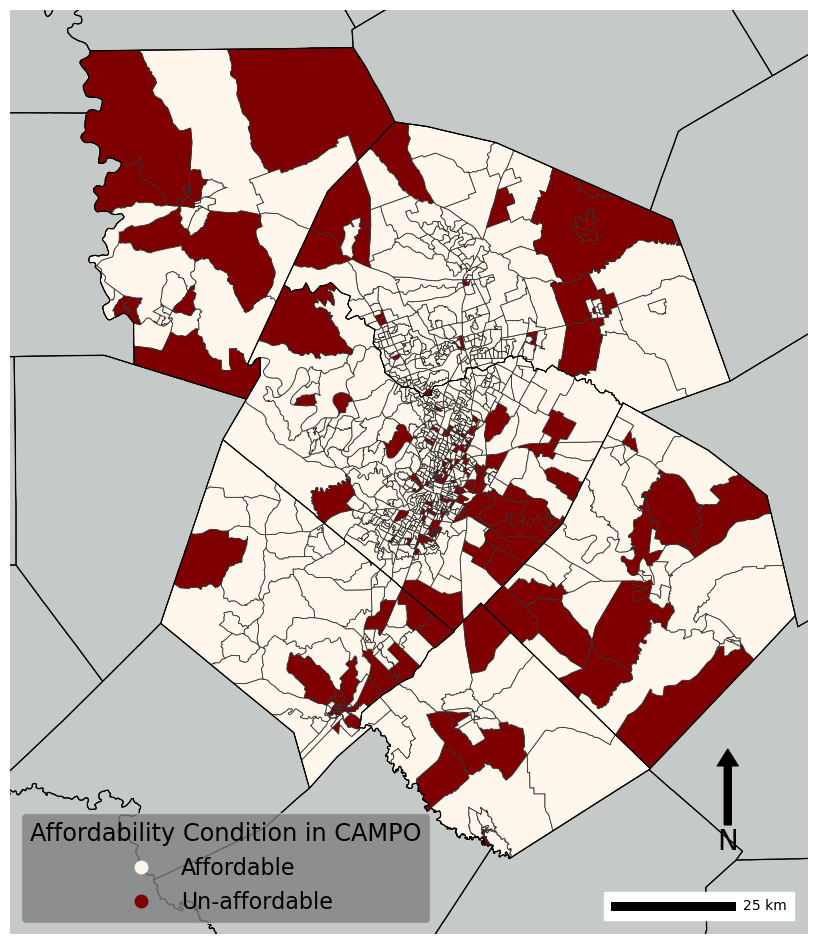

In [12]:
# Create single comprehensive subplots 


variable = H_Tcost['Affordability'] # define target variable


fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1]) # set axis


# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column= variable, categorical=True, cmap='OrRd', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'loc':'lower left','fontsize':16,'frameon':True,'facecolor':'grey'}, ax=ax,zorder = 1)

# add legend title
ax.get_legend().set_title("Affordability Condition in CAMPO",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

ax.axis('off')

fig.savefig('images/affordable_index.png')

#### Total Housing Cost  

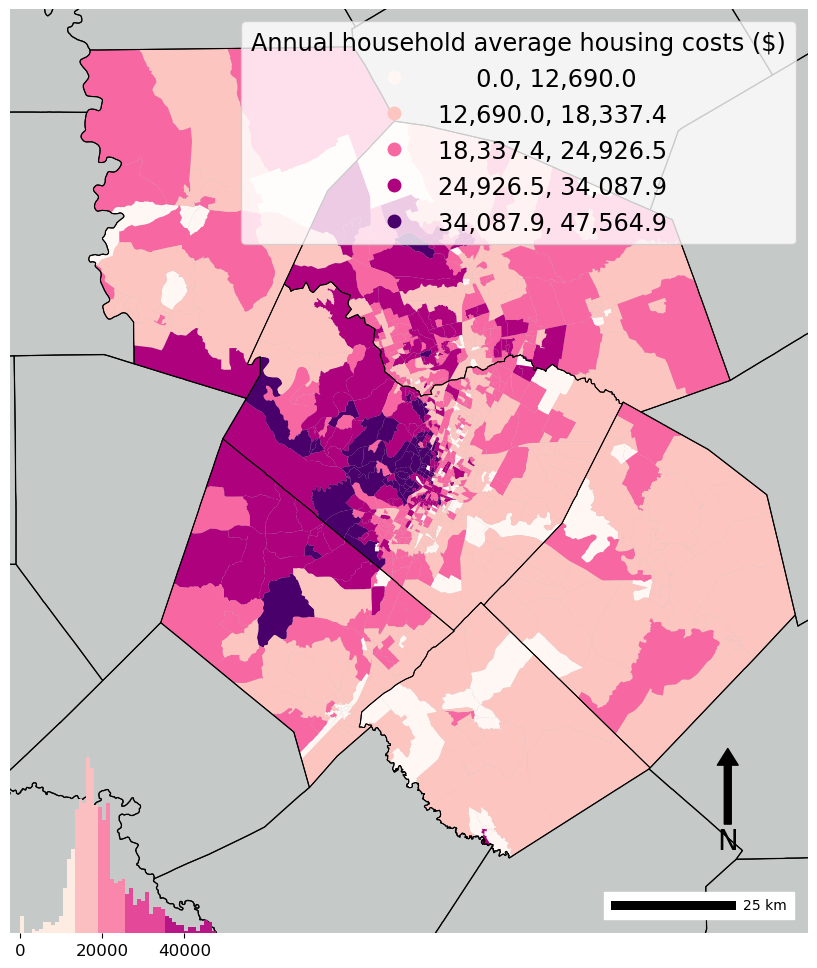

In [13]:
# Create single comprehensive subplots 


variable = H_Tcost['ave_housing_yearly'] # define target variable

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1])  # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)

ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household average housing costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/annual_hh_housing_costs.png')

#finding: 8 block groups have 0 housing mortgage cost or rent cost, leading to the 0 annual costs there

#### Transit Use

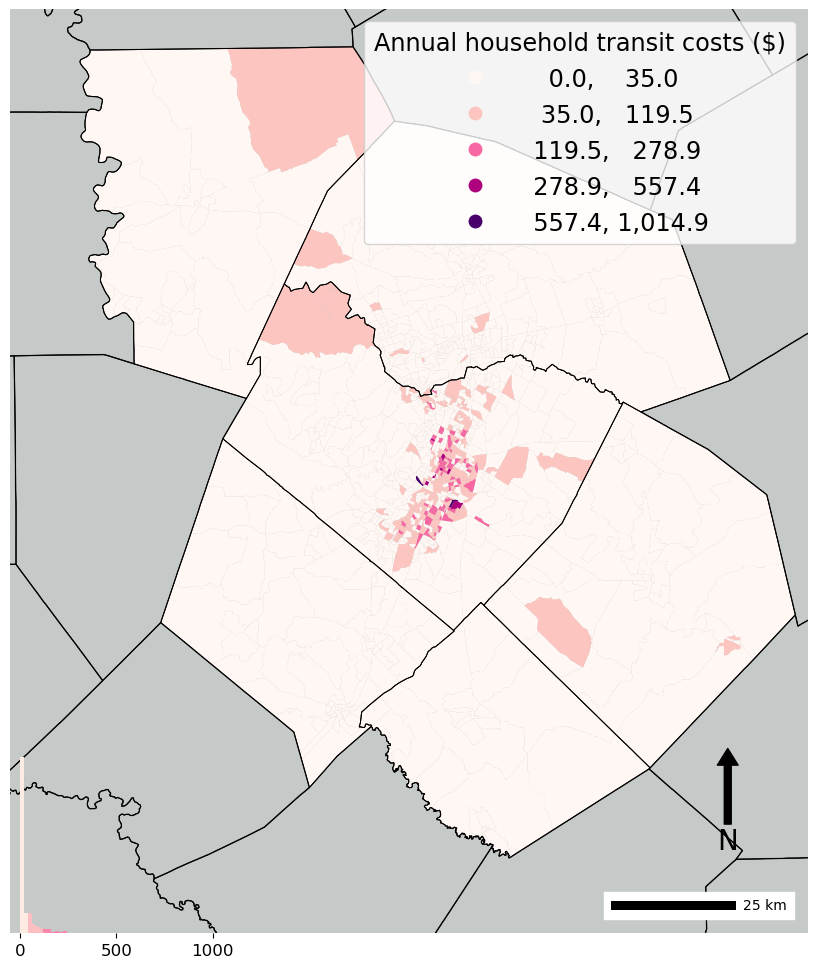

In [14]:
# Create single comprehensive subplots 

variable = H_Tcost['transitcost_hh'] # define target variable

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1])  # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
           legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)


ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household transit costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/annual_hh_transit_costs.png')


#### Auto-ownership expense

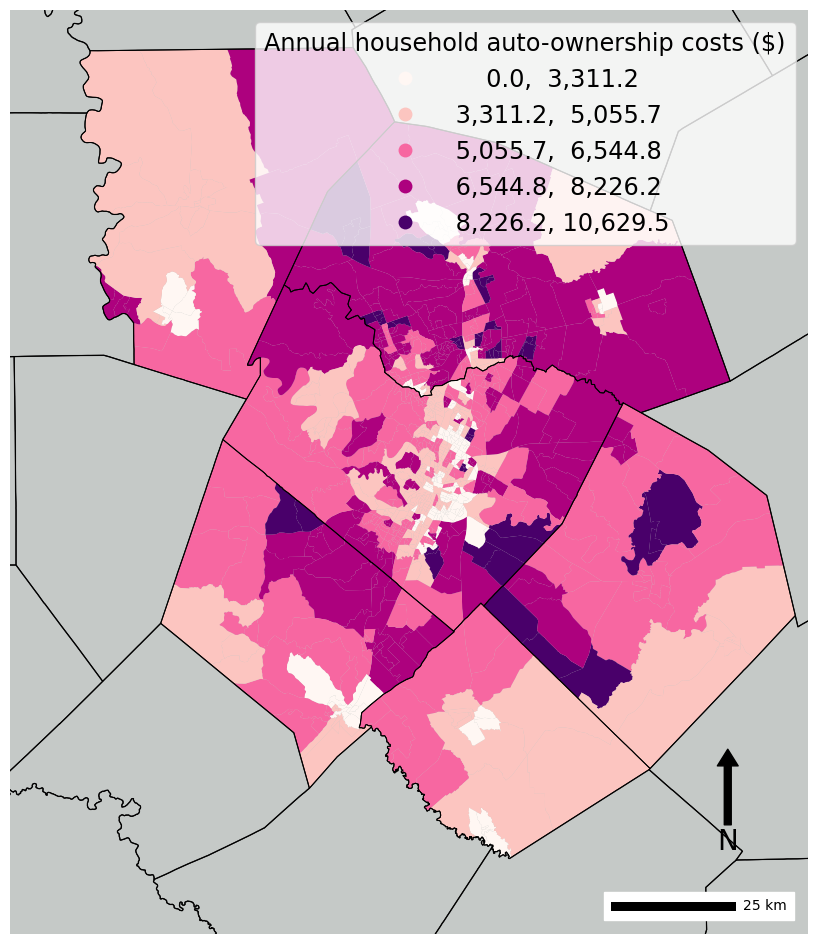

In [15]:
# Create single comprehensive subplots 

variable = H_Tcost['carownership_expense_hh'] # define target variable

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1])  # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)


ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household auto-ownership costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


fig.savefig('images/annual_hh_auto_ownership_costs.png')


#### AutoUse Driving Cost

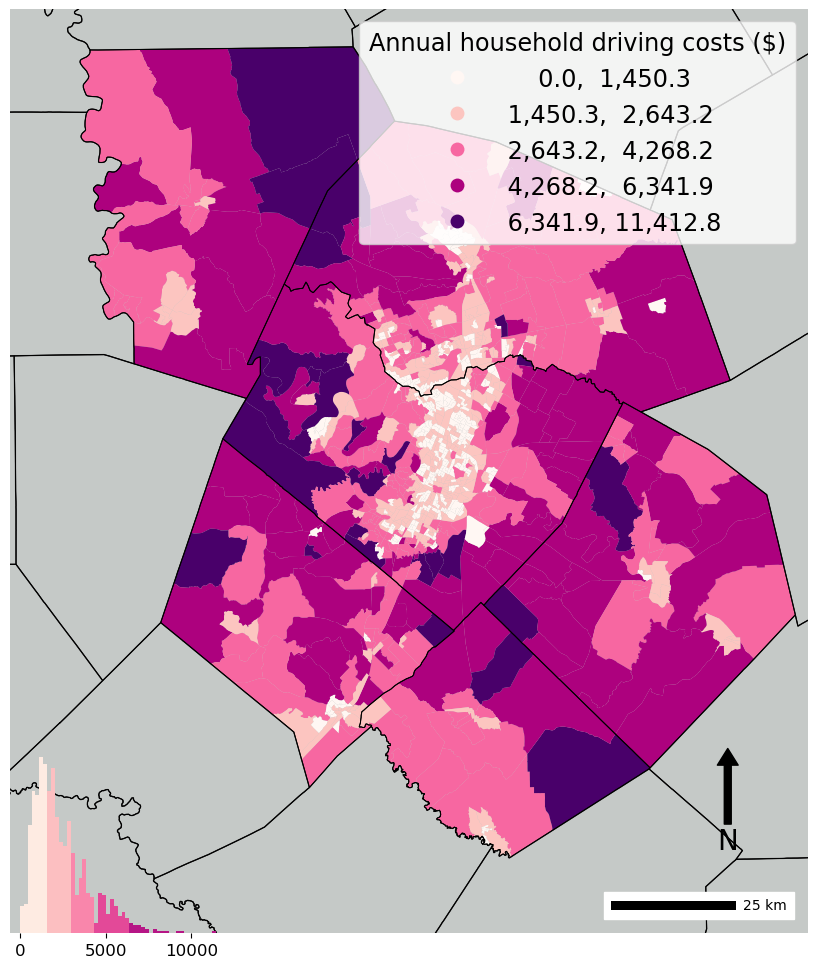

In [16]:
# Create single comprehensive subplots 

variable = H_Tcost['driving_cost_year'] # define target variable

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1])  # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)

ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household driving costs ($)",prop={'size':'xx-large'}) 

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/annual_hh_driving_costs.png')


#### Median Income

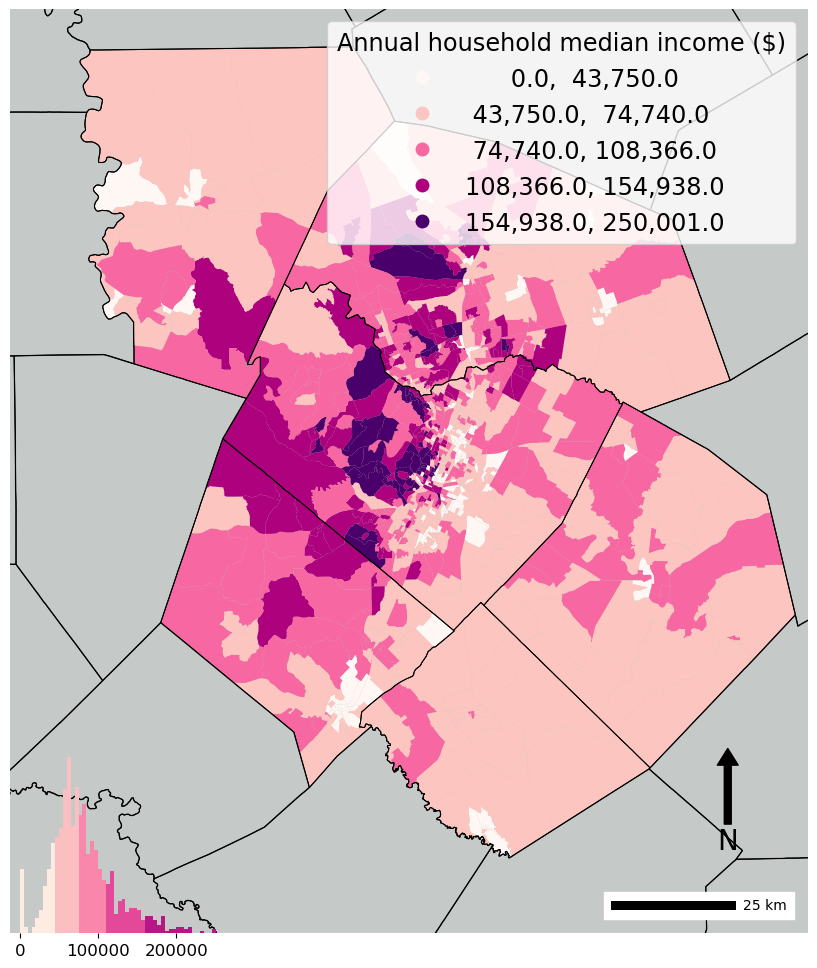

In [17]:
# Create single comprehensive subplots 


variable = H_Tcost['medincome'] # define target variable

fig, ax = plt.subplots(1, 1, figsize = (20, 12)) # set plot size
ax.axis([-98.6,-97,29.5,31.1])  # set axis

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax=ax, zorder=2)

# plot selected variable
H_Tcost.plot(column = variable,
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
             legend=True,
            legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")),
            zorder = 1)

ax.axis('off') #Get rid of grids, and x/y axis

# add legend title
ax.get_legend().set_title("Annual household median income ($)",prop={'size':'xx-large'}) 


# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=variable, k=5).bins # #extract the natural_break threshold values and get corresponding bins

hax = legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = variable, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5# the palette to use
          )

fig.savefig('images/annual_hh_median_income.png')


### Other mapping

#### Housing Costs and Median income 

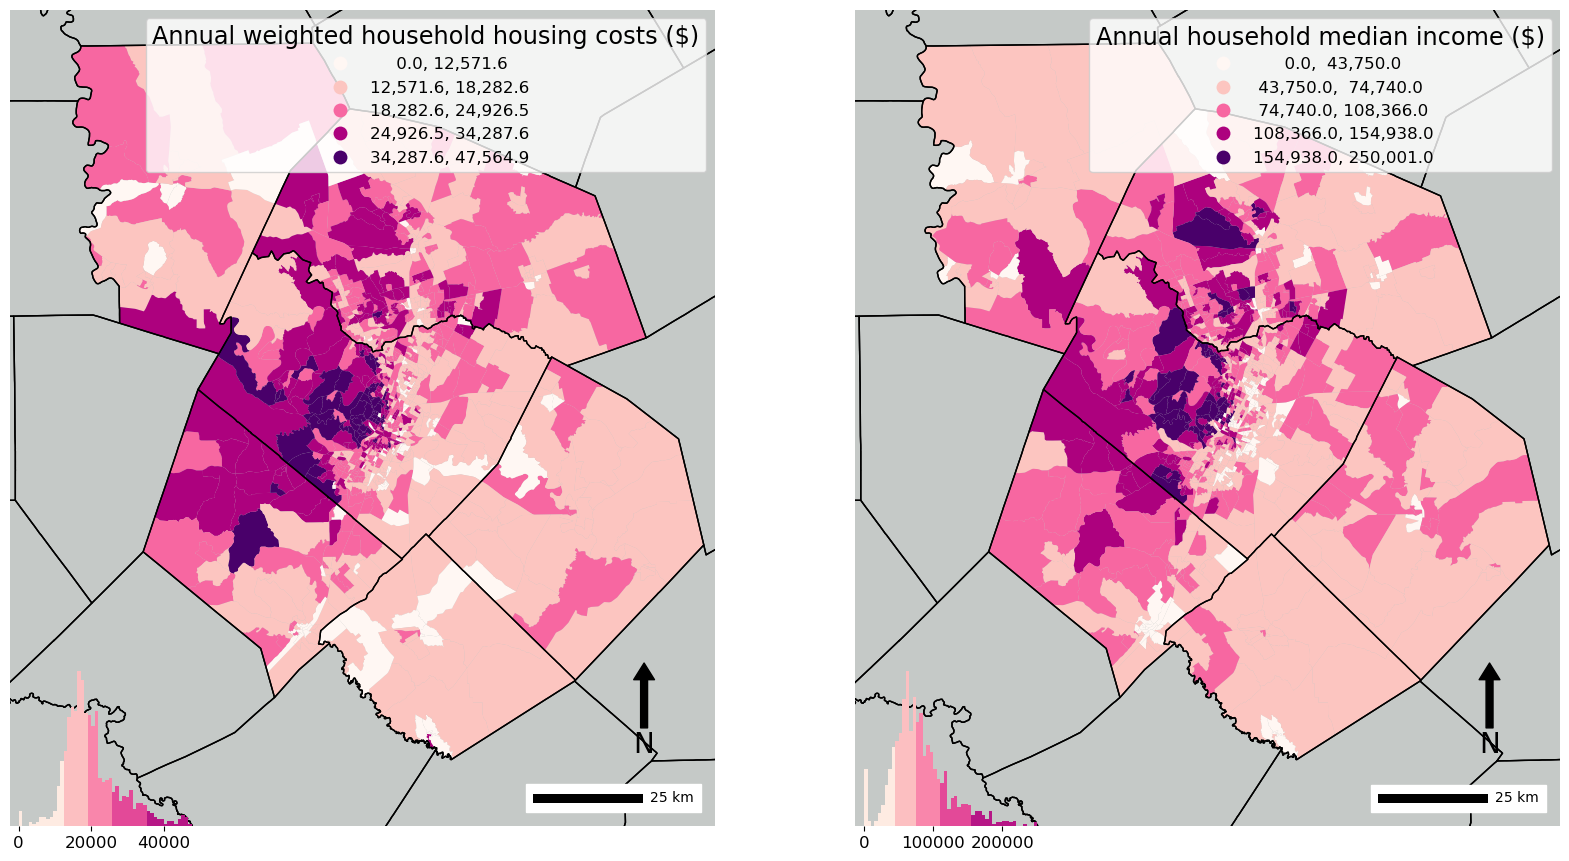

In [18]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15)) # set plot size

ax[0].axis([-98.6,-97,29.5,31.1]) # set axis for the left map
ax[1].axis([-98.6,-97,29.5,31.1]) # set axis for the right map
 
### housing (left map) ####

# County Boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)

  # plot selected variable
H_Tcost.plot(column = "ave_housing_yearly",
            ax=ax[0],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='large',fmt="{:,.1f}")),
            zorder = 1)

ax[0].get_legend().set_title("Annual weighted household housing costs ($)",prop={'size':'xx-large'}) # add legend title

ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.ave_housing_yearly, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[0], # the axis to add the legend
           y = H_Tcost.ave_housing_yearly, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )


### median income (right map) ####

# County Boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)

  # plot selected variable
H_Tcost.plot(column = "medincome",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].axis('off') #Get rid of grids, and x/y axis

# add legend title
ax[1].get_legend().set_title("Annual household median income ($)",prop={'size':'xx-large'}) 


# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.medincome, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[1], # the axis to add the legend
           y = H_Tcost.medincome, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/housing_median_income.png')

#### County map

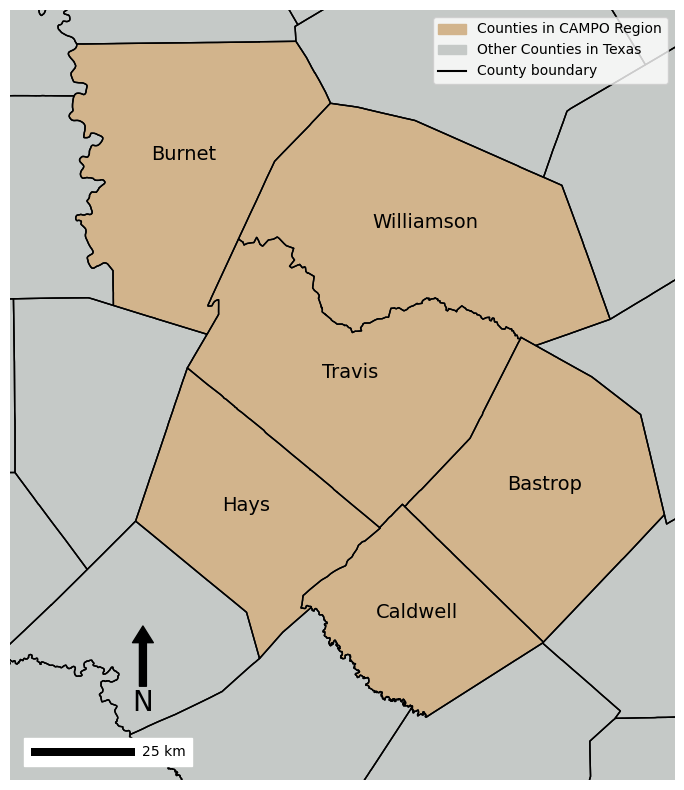

In [19]:
# Create subplots - County mapping

fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data

ax.axis([-98.6,-97,29.5,31.1])

# All counties in TX
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax, zorder=2)

# 6 counties in CAMPO region
campo_county.plot(color='tan',edgecolor='grey',linewidth = 1,ax=ax, zorder = 1)
campo_county.apply(lambda x: ax.annotate(text=x.namelsad, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)


ax.axis('off') #Get rid of grids, and x/y axis

ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower left"))

# add North arrow
x, y, arrow_length = 0.2, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


# add legend

campo_area = mpatches.Patch(color='tan', label='Counties in CAMPO Region')
texas_area = mpatches.Patch(color='#C5C9C7', label='Other Counties in Texas')
#Create Line Legend Entries
bd_c  = mlines.Line2D([], [], color='black', marker='',
                      markersize=15, label='County boundary')

plt.legend(handles=[campo_area, texas_area,bd_c])



fig.savefig('images/county_boundary.png')
